In [1]:
from sklearn.linear_model import RidgeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone
import pandas as pd
from yikit.models import Objective
from yikit.tools.visualization import get_learning_curve_optuna
import optuna

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = pd.Series(data.target)
display(X, y)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


0      0
1      0
2      0
3      0
4      0
      ..
564    0
565    0
566    0
567    0
568    1
Length: 569, dtype: int64

In [3]:
SEED = 334

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2, stratify=y)

ベンチマーク

In [5]:
estimator = RidgeClassifier(random_state=SEED)
accuracy_score(estimator.fit(X_train, y_train).predict(X_test), y_test)

0.9649122807017544

ハイパーパラメータ探索

In [6]:
def custom_params(trial):
    return {
        'alpha': trial.suggest_loguniform('alpha', 1e-2, 1e2),
        'normalize': trial.suggest_int('normalize', 0, 1)
    }

In [7]:
kf = StratifiedKFold(n_splits=4, shuffle=False)
objective = Objective(clone(estimator), X_train, y_train, custom_params, cv=kf, random_state=SEED, scoring='accuracy', n_jobs=-1)

In [8]:
study = optuna.create_study(sampler=objective.sampler, direction='maximize')
study.optimize(objective, n_trials=50, n_jobs=1)

[I 2022-06-27 21:03:49,983] A new study created in memory with name: no-name-9db7d55f-e130-4c18-a545-340a37bccceb
/Users/yu9824/miniforge3/envs/yikit/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/yu9824/miniforge3/envs/yikit/lib/python3.9/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(
/Users/y

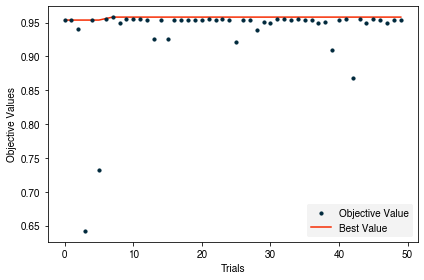

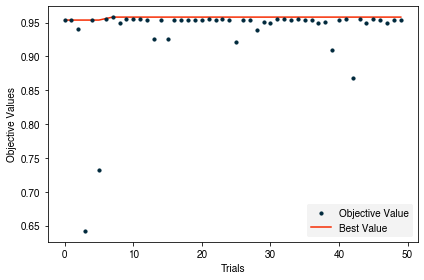

In [9]:
get_learning_curve_optuna(study=study)

In [10]:
estimator_opt = clone(estimator).set_params(**study.best_params, **objective.fixed_params_)
accuracy_score(estimator_opt.fit(X_train, y_train).predict(X_test), y_test)

/Users/yu9824/miniforge3/envs/yikit/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), RidgeClassifier())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * n_samples. 
  warnings.warn(


0.9824561403508771

In [11]:
estimator_opt, estimator

(RidgeClassifier(alpha=0.015936234610515895, normalize=1, random_state=334),
 RidgeClassifier(random_state=334))